# Developing a toy model for exploring uncertainties in the Pearson correlation coefficient

We want a model framework that produces "climate-like" signals with the following properties:
- ability to dial up/down the serial correlation
- ability to dial up/down the number of ensemble members to produce realistic smoothing
- explore the effect of trends

In [46]:
import numpy as np

import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import Divider, Size

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess

import cartopy
import cartopy.crs as ccrs

cartopy.config["pre_existing_data_dir"] = f"{DATA_DIR}/cartopy-data"
cartopy.config["data_dir"] = f"{DATA_DIR}/cartopy-data"

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [134]:
DATA_DIR = "../../data/"

## Load some example real signals to try and replicate

In [146]:
can = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5_ctrl.annual.anom_6571-6600.precip_global.zarr"
)
can["t_ref"] = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5_ctrl.annual.anom_6571-6600.t_ref_global.zarr"
)["t_ref"]
can["sst"] = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5_ctrl.annual.anom_6571-6600.sst_global.zarr"
)["sst"]

## What do the partial autocorrelation functions look like for these fields?

In [148]:
def acf(ds, dim="time", partial=False, nlags=10):
    """Vectorized Autocorrelation Function for xarray objects"""
    import statsmodels.api as sm

    def _acf(data, nlags, partial):
        if partial:
            return sm.tsa.pacf(data, nlags=nlags)
        else:
            return sm.tsa.acf(data, nlags=nlags)

    return xr.apply_ufunc(
        _acf,
        ds,
        kwargs=dict(nlags=nlags, partial=partial),
        input_core_dims=[[dim]],
        output_core_dims=[["lag"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        dask_gufunc_kwargs=dict(output_sizes={"lag": nlags + 1}),
    ).assign_coords({"lag": range(nlags + 1)})

In [149]:
pacf_can = acf(can, partial=True)

In [152]:
def plot_pacf_lags(pacf, lags, figsize=(15, 8), vrange=(-1, 1)):

    fig = plt.figure(figsize=figsize)
    axs = fig.subplots(
        len(pacf),
        len(lags),
        sharex=True,
        sharey=True,
        subplot_kw=dict(projection=ccrs.PlateCarree(180)),
    )

    bounds = np.linspace(vrange[0], vrange[1], 21)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds) - 1)

    for x, l in enumerate(lags):
        for y, v in enumerate(pacf.keys()):
            ax = axs[x, y]
            p = (
                pacf[v]
                .sel(lag=l)
                .plot(
                    ax=ax,
                    transform=ccrs.PlateCarree(),
                    vmin=vrange[0],
                    vmax=vrange[1],
                    norm=norm,
                    cmap="RdBu_r",
                    add_colorbar=False,
                )
            )
            p.axes.coastlines(color=[0.2, 0.2, 0.2], linewidth=0.75)

            ax.set_title(f"{v} | lag {l}")

    h = [Size.Fixed(figsize[0] / 12), Size.Fixed(figsize[0] - figsize[0] / 6)]
    v = [Size.Fixed(0), Size.Fixed(0.15)]
    divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
    cbar_ax = fig.add_axes(
        divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=1)
    )
    fig.colorbar(p, cax=cbar_ax, orientation="horizontal")

    return fig

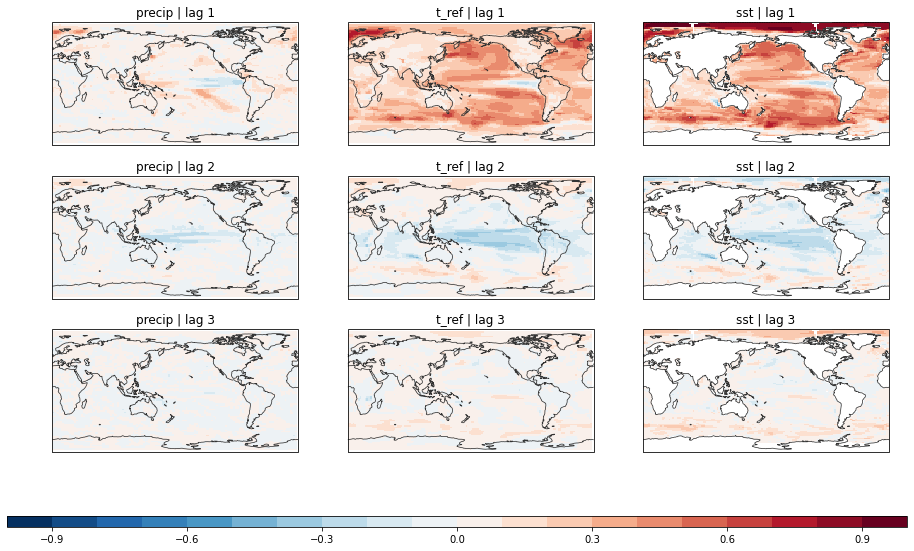

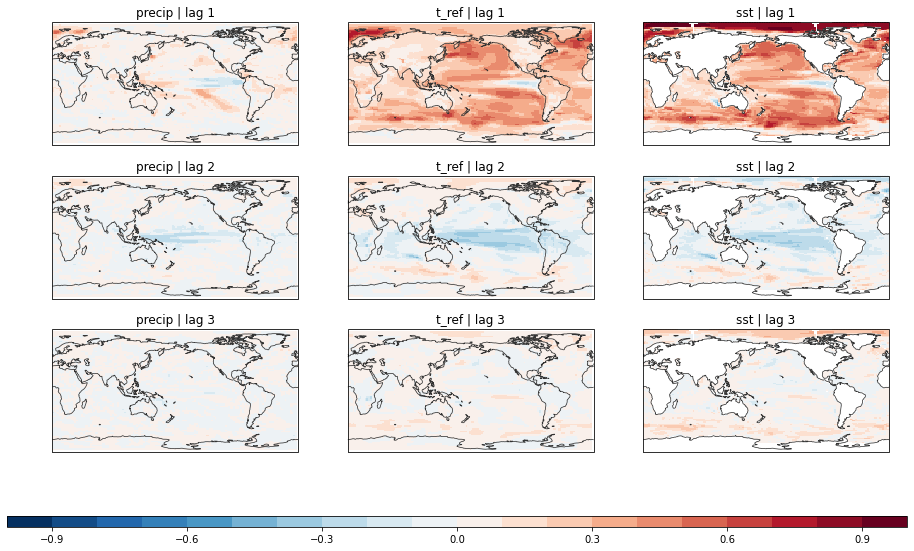

In [153]:
_ = plot_pacf_lags(pacf_can, lags=[1, 2, 3])

In [173]:
nsamples = 10000
ntimes = 50

ar = np.array([1, -0.7, 0.2])

arma_process = ArmaProcess(ar)
s = arma_process.generate_sample(nsample=nsamples)

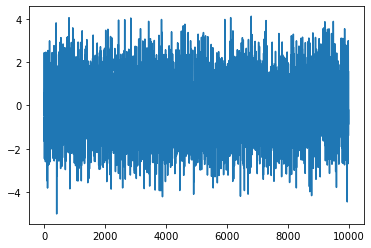

In [174]:
plt.plot(s)

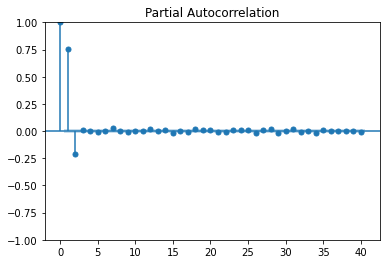

In [172]:
_ = plot_pacf(s, method="ywm")